# Исследование надёжности заёмщиков

Входные данные от банка — статистика о платёжеспособности клиентов.

**Задачи** 

Разобраться, влияет ли на факт погашения кредита в срок:
1. Семейное положение.
2. Наличие детей.
3. Уровень дохода.
4. Цели кредитования.

Если влияют, то как?

**Цель**

Интерпретировать результат и на основании исследования дать рекомендации при построении модели **кредитного скоринга**.

##  Общая информация о данных

Импортируем библиотеку pandas и сохраним данные в `df`. Посмотрим, что из себя представляют первые 20 строк.

In [2]:
import pandas as pd
df = pd.read_csv('/datasets/data.csv')
display(df.head(20))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


Сразу бросаются в глаза отрицательные значения в столбце с количеством рабочих дней. Разный регистр в столбце образование. Пропущены значения в стобце с доходом и количеством рабочих дней.

Посмотрим на общую информацию, используя метод `info()`

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Переименуем название стобца с возрастом клиента, так как его название не отражает содержимое.

In [94]:
df = df.rename({'dob_years':'clients_age'}, axis='columns')

In [95]:
df.isna().mean()

children            0.000000
days_employed       0.100999
clients_age         0.000000
education           0.000000
education_id        0.000000
family_status       0.000000
family_status_id    0.000000
gender              0.000000
income_type         0.000000
debt                0.000000
total_income        0.100999
purpose             0.000000
dtype: float64

Всего 21525 строк, при этом в стобцах с доходом `total_income` и стажем `days_employed` не хватает одинакового количества значений - 2174, это 10%.

Попробуем найти артефакты в каждом из столбцов с помощью `value_counts()`.

In [96]:
for row in df:
    display(df[row].value_counts())

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

-986.927316     1
-7026.359174    1
-4236.274243    1
-6620.396473    1
-1238.560080    1
               ..
-2849.351119    1
-5619.328204    1
-448.829898     1
-1687.038672    1
-582.538413     1
Name: days_employed, Length: 19351, dtype: int64

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: clients_age, dtype: int64

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

0    19784
1     1741
Name: debt, dtype: int64

112874.418757    1
133912.272223    1
182036.676828    1
122421.963500    1
198271.837248    1
                ..
133299.194693    1
115080.782380    1
84896.781597     1
153838.839212    1
150014.128510    1
Name: total_income, Length: 19351, dtype: int64

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

* `children `. Значение "20" скорее всего ошибка, должно быть "2". "-1" - скорее всего "1"
* `clients_age`. 101 человек с возрастом 0. Опечатка, могло быть "20", "30"... итд. Заменим медианой в зависимости от типа занятости.
* `education`. Привести все значения к одному регистру.
* `gender`. 1 клиент без значения, можно удалить.
* `days_employed`. Отрицательные значения. 
* `purpose`. Одинаковые по семантике, но разные по написанию цели взятия кредита.
* `education`. Разный регистр у одинаковых категорий.

Отредактируем все эти ошибки:

In [97]:
df['children'] = df['children'].replace(20, 2)
df['children'] = df['children'].replace(-1, 1)

df = df[df['gender'] != 'XNA']
df['education'] = df['education'].str.lower()
df['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

Чтобы заполнить пропущенные значения в возрасте, мы сгруппируем данные по типу занятости и для каждой группы найдём медианное значение. Затем с помощью цикла для всех пропусков проверим тип занятости и подставим готовое значение. Сразу проверим результат.  

In [98]:
income_type_group_by_age = df.groupby('income_type')['clients_age'].median()

income_type_array = df['income_type'].unique()

for type in income_type_array:
    df.loc[(df['income_type'] == type) & (df['clients_age'] == 0), 'clients_age'] = income_type_group_by_age[type]

df['clients_age'].isna().sum()

0

**Описание данных**

- `children` — количество детей в семье
- `days_employed` — общий трудовой стаж в днях
- `dob_years` — возраст клиента в годах (переименовали в `clients_age`)
- `education` — уровень образования клиента
- `education_id` — идентификатор уровня образования
- `family_status` — семейное положение
- `family_status_id` — идентификатор семейного положения
- `gender` — пол клиента
- `income_type` — тип занятости
- `debt` — имел ли задолженность по возврату кредитов
- `total_income` — ежемесячный доход
- `purpose` — цель получения кредита

В каждом столбце хранятся значения одной переменной, каждая стррока содержит одно наблюдение за клиентом. В названии столбцов соблюдены условия: отсутствие пробелов; несколько слов разделяются нижним подчеркивание; все названия на одном языке и в одном регистре; названия отражают какого рода информация в каждом столбце.

**Вывод** просмотрев общую информацию о таблице выявили следующие проблемы:
1. В столбцах `days_employed`, `total_income`  встречаются «нулевые», пропущенные значения. Их доля составляет 10%, значит придётся их обработать прежде, чем анализировать данные.
2. В стобцах `education`, `purpose` есть очевидные смысловые дубликаты, написанные в разном регистре, либо немного другой формулировке, не меняющей смысловой нагрузки. Так как это категориальные данные, есть смысл доработать программу заведения заявок таким образом, чтобы основные категории отражались (у менеджера - если это оффлайн заявка/на сайте - если онлайн) в виде выпадающего списка. Это облегчит процесс категоризации данных по этим параметрам в будущем.
3. Сообщить команде о найденных проблемах и попытаться разобраться в причинах появления пропусков и некорректных категорий.

## Предобработка данных

### Обработка пропусков

На этапе ознакомления данных мы обнаружили, что в стобцах `days_employed`, `total_income` есть пропуски.
Возможными причинами могут быть: ошибки ввода данных, сокрытие информации, фрод.
Так как в обоих столбцах строго одинаковое количество пропусков, проверим гипотезу о том, что если не указано значение в одном столбце, то не указано и в другом. 

In [99]:
df[(df['total_income'].isna()) | (df['days_employed'].isna())]

,children,days_employed,clients_age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65.0,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41.0,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63.0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50.0,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54.0,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47.0,среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50.0,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48.0,высшее,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42.0,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


Количество строк, удовлетворяющих условию *в одном из стобцов `days_employed`, `total_income` значение NaN* совпадает с количеством пропусков. Гипотеза подтвердилась - если в строке нет данных общего трудовго стажа, то в ней нет данных совокупного ежемесячного дохода. Возможная причина - человек никогда не был официально трудоустроен и не имеет возможности подтвердить свой доход. Доход либо неофициальный, либо отсутствует как таковой. 

Мы выявили строгую закономерность, поэтому можем отнести эти пропуски к категории **MNAR**. Она предполагает, что вероятность пропуска могла бы быть описана на основе другого атрибута, но информация по этому атрибуту в наборе данных отсутствует.

Оба столбца содержат в себе количественные переменные, значит будем заполнять их характерными значениями.
Для этого подробнее изучим выборку этих столбцов: найдём максимальные и минимальные значения, а также медиану и среднее.

In [100]:
df['total_income'].agg(['min','max'])

min    2.066726e+04
max    2.265604e+06
Name: total_income, dtype: float64

In [101]:
df['total_income'].agg(['mean','median'])

mean      167420.416789
median    145011.709296
Name: total_income, dtype: float64

In [102]:
df['days_employed'].agg(['min','max'])

min    -18388.949901
max    401755.400475
Name: days_employed, dtype: float64

In [103]:
df[df['days_employed'] < 0]['days_employed'].count()

15905

**Вывод:**
Диапазон значений в столбце `total_income` составляет 20667-2265604, что выглядит адекватным. Среднее значение составляет 167422.3, медиана составляет 145017.9. Судя ощутимой разнице, в выборке есть большие значения, которые сдвигают среднее значение, значит заменим пропуски медианой - она более репрезантативна. 

В столбце `days_employed` присутствуют отрицательные значения, что не может отражать реальную действительность. Таких значений более 82%. Если есть возможность, то я бы обратился к коллегам, поставляющим базы и уточнил детали. В нашем случае будем довольствоваться самым логичным объяснением. Для начала нужно предположить, каким образом расчитывается значение: скорее всего это делается автоматически: из одной даты вычитают другую и приводят значение к дням. Если нарушить порядок дат и вычесть более позднюю из более ранней, то значение будет отрицательным. Хотя по абсолютному значению будет совпадать с действительным. Поэтому в данном столбце мы просто заменим значения на абсолютные.

In [104]:
df.loc[:, 'days_employed'] = abs(df.loc[:, 'days_employed'])

Посмотрим, насколько равномерно распределены возрастные группы.

(array([  65.,  294.,  517.,  765.,  996., 1085., 1070.,  581., 1220.,
        1092., 1246., 1222., 1110., 1044.,  475., 1018., 1022.,  932.,
         938.,  930.,  921.,  841.,  355.,  621.,  459.,  350.,  184.,
         123.,   41.,    7.]),
 array([19.        , 20.86666667, 22.73333333, 24.6       , 26.46666667,
        28.33333333, 30.2       , 32.06666667, 33.93333333, 35.8       ,
        37.66666667, 39.53333333, 41.4       , 43.26666667, 45.13333333,
        47.        , 48.86666667, 50.73333333, 52.6       , 54.46666667,
        56.33333333, 58.2       , 60.06666667, 61.93333333, 63.8       ,
        65.66666667, 67.53333333, 69.4       , 71.26666667, 73.13333333,
        75.        ]),
 <a list of 30 Patch objects>)

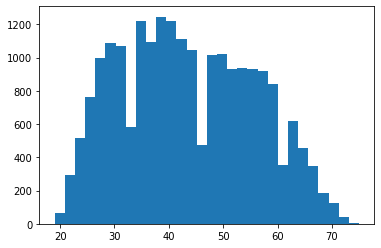

In [105]:
import matplotlib.pyplot as plt
plt.hist(df['clients_age'], bins=30)

Если мы посмотрим на диаграмму распределения по возрасту, то увидим, что есть провалы, для более корректного заполнения трудового стажа и зарплаты будет лучше разбить медианные значения по этим группам.
* первая группа до 35 лет (далее в переменных `_first`)
* вторая группа 35-45 лет (далее в переменных `_second`)
* третья группа 45-60 лет (далее в переменных `_third`)
* четвертая группа старше 60 лет (далее в переменных `_fourth`)

In [106]:
df['days_employed'].agg(['mean','median'])

mean      66918.065141
median     2194.218768
Name: days_employed, dtype: float64

In [107]:
age_first = df[df['clients_age'] < 35]['days_employed'].median()
age_first

1178.0181626540525

In [108]:
age_second = df[(df['clients_age'] >= 34) & (df['clients_age'] < 45)]['days_employed'].median()
age_second

1813.2783513997424

In [109]:
age_third = df[(df['clients_age'] >= 45) & (df['clients_age'] < 60)]['days_employed'].median()
age_third

3354.4549020116565

In [110]:
age_fourth = df[df['clients_age'] >= 60]['days_employed'].median()
age_fourth

355324.8233531044

В силу того, что трудовой стаж такая характеристика, которая имеет накопительный эффект и значительно изменяется с возрастом, неправильно было бы брать общие значения для всех. 

In [111]:
data = [df['days_employed'].median(), age_first, age_second, age_third, age_fourth]
columns = ['Медиана стажа по группам']
pd.DataFrame(data=data, columns=columns, index=['средняя', 'до 35', '35-45', '45-60', 'старше 60'])

,Медиана стажа по группам
средняя,2194.218768
до 35,1178.018163
35-45,1813.278351
45-60,3354.454902
старше 60,355324.823353


Произведем замену пустых значений:

In [112]:
df['days_employed'] = df['days_employed'].fillna(0)

df.loc[(df['clients_age'] < 35) & (df['days_employed'] == 0), 'days_employed'] = age_first
df.loc[(df['clients_age'] >= 34) & (df['clients_age'] < 45) & (df['days_employed'] == 0), 'days_employed'] = age_second
df.loc[(df['clients_age'] >= 45) & (df['clients_age'] < 60) & (df['days_employed'] == 0), 'days_employed'] = age_third
df.loc[(df['clients_age'] >= 60) & (df['days_employed'] == 0), 'days_employed'] = age_fourth

df['clients_age'].isna().sum()

0

Займёмся пропущенными значения в столбце с доходом. По тому же принципу, вначале посчитаем медиану для каждой группы и заполним пропуски.

In [113]:
income_first = df[df['clients_age'] < 35]['total_income'].median()
income_second = df[(df['clients_age'] >= 34) & (df['clients_age'] < 45)]['total_income'].median()
income_third = df[(df['clients_age'] >= 45) & (df['clients_age'] < 60)]['total_income'].median()
income_fourth = df[df['clients_age'] >= 60]['total_income'].median()

data = [df['total_income'].median(), income_first, income_second, income_third, income_fourth]
columns = ['Медиана дохода по группам']
pd.DataFrame(data=data, columns=columns, index=['средняя', 'до 35', '35-45', '45-60', 'старше 60'])

,Медиана дохода по группам
средняя,145011.709296
до 35,146233.271894
35-45,155157.239359
45-60,144175.823134
старше 60,123419.911371


Произведем замену пустых значений:

In [114]:
df['total_income'] = df['total_income'].fillna(0)

df.loc[(df['clients_age'] < 35) & (df['days_employed'] == 0), 'total_income'] = income_first
df.loc[(df['clients_age'] >= 34) & (df['clients_age'] < 45) & (df['days_employed'] == 0), 'total_income'] = income_second
df.loc[(df['clients_age'] >= 45) & (df['clients_age'] < 60) & (df['days_employed'] == 0), 'total_income'] = income_third
df.loc[(df['clients_age'] >= 60) & (df['days_employed'] == 0), 'total_income'] = income_fourth

df['total_income'].isna().sum()

0

(array([2.180e+03, 2.180e+02, 1.109e+03, 2.077e+03, 2.682e+03, 2.545e+03,
        2.357e+03, 2.018e+03, 1.528e+03, 1.115e+03, 8.540e+02, 7.420e+02,
        5.300e+02, 3.100e+02, 2.830e+02, 2.020e+02, 1.610e+02, 1.260e+02,
        8.600e+01, 7.800e+01, 4.500e+01, 5.200e+01, 3.600e+01, 2.900e+01,
        2.500e+01, 1.700e+01, 1.300e+01, 9.000e+00, 1.400e+01, 1.300e+01,
        1.200e+01, 6.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 1.000e+00,
        4.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

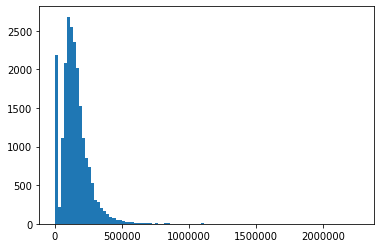

In [115]:
plt.hist(df['total_income'], bins=100)

In [116]:
by_income_dict = {
    0: 'Доход до 50к.',
    1: 'Доход 50-120к.',
    2: 'Доход 120-200к.',
    3: 'Доход более 200к.',
}

def group_by_income(row):
    income = row['total_income']
    
    if income <= 50000:
        return 0
    if income <= 120000:
        return 1
    if income <= 200000:
        return 2
    return 3

df['income_id'] = df.apply(group_by_income, axis=1)

Итак, мы определили пропущенные значения, пояснили их и описали возможные причины появления. Затем заполнили пропуски, попутно объяснив принцип заполнения. Также сгруппировали данные по доходу, назначив каждому диапазону айди, это поможет нам в заключительной части исследования. Проверили результат - всё отлично, можем работать дальше. 

### Замена типа данных

Для замены типов данных в стобцах `days_employed`,`total_income` воспользуемся методом `astype()`,так как в этих стобцах нет строковых значений, которые потребуется преобразовать, конструкция `try-except` в данном случае не понадобится.

In [117]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
df['clients_age'] = df['clients_age'].astype('int')

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21524 entries, 0 to 21524
Data columns (total 13 columns):
children            21524 non-null int64
days_employed       21524 non-null int64
clients_age         21524 non-null int64
education           21524 non-null object
education_id        21524 non-null int64
family_status       21524 non-null object
family_status_id    21524 non-null int64
gender              21524 non-null object
income_type         21524 non-null object
debt                21524 non-null int64
total_income        21524 non-null int64
purpose             21524 non-null object
income_id           21524 non-null int64
dtypes: int64(8), object(5)
memory usage: 2.3+ MB


**Вывод**: в стобцах `days_employed`,`total_income`, `clients_age` заменили вещественный тип данных на целочисленный. Проверили с помощью метода `info()`, всё ок. 

### Обработка дубликатов

In [119]:
df.duplicated().sum()

71

В выборке отсутствуют данные об уникальных идентификаторах, по которым можно было бы легко отследить дубли. Попробуем автоматический поиск с помощью метода `duplicated().sum()` - в результате получили 71 строки. Удалим их с помощью метода `.drop_duplicates()` и обновим индексацию.

In [120]:
df = df.drop_duplicates().reset_index(drop=True)

**Вывод:** мы вывели все потенциальные дубликаты автоматическим способом. Так как у нас нет уникальных идентификаторов, то мы можем полагаться лишь на то, что значения абсолютно во всех стобцах совпадут, считаем, что это сбой базы, а не разные люди, и удаляем.

### Лемматизация

Чтобы провести лемматизацию выгрузим необходимый модуль `pymystem3`. Выгрузим список уникальных целей и лемматизируем их.

In [121]:
from pymystem3 import Mystem
unique_purposes = df['purpose'].unique()
all_lemmas = []
for purpose in unique_purposes:
    lemma = Mystem().lemmatize(purpose)
    all_lemmas.append(lemma)
all_lemmas

[['покупка', ' ', 'жилье', '\n'],
 ['приобретение', ' ', 'автомобиль', '\n'],
 ['дополнительный', ' ', 'образование', '\n'],
 ['сыграть', ' ', 'свадьба', '\n'],
 ['операция', ' ', 'с', ' ', 'жилье', '\n'],
 ['образование', '\n'],
 ['на', ' ', 'проведение', ' ', 'свадьба', '\n'],
 ['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n'],
 ['покупка', ' ', 'недвижимость', '\n'],
 ['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n'],
 ['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n'],
 ['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n'],
 ['недвижимость', '\n'],
 ['строительство', ' ', 'недвижимость', '\n'],
 ['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n'],
 ['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n'],
 ['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n'],
 ['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n'],
 ['жилье', '\n'],
 ['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n'],
 ['автомобиль'

Создадим функцию, которая будет возвращать леииы в виде строк, пройдём по всему стобцу целей и добавим рядом новый, обработанный.  

In [122]:
import json
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

In [123]:
def lem(purpose):
    lemma = ' ' .join(m.lemmatize(purpose))
    return lemma

df['purpose_lemma'] = df['purpose'].apply(lem)

Создадим функцию для того, чтобы присвоить каждой строке категорию, в зависимости от того, какое из ключевых слов содержится в столбце `purpose_lemma`.

In [124]:
purpose_dict = {
    0: 'автомобиль',
    1: 'недвижимость',
    2: 'жилье',
    3: 'свадьба',
    4: 'образование',
    5: 'строительство',
}

def categ_purpose(lemma):
    if 'автомобиль' in lemma:
        return 0
    if 'недвижимость' in lemma:
        return 1
    if 'жилье' in lemma:
        return 2
    if 'свадьба' in lemma:
        return 3
    if 'образование' in lemma:
        return 4
    if 'строительство' in lemma:
        return 5

df['purpose_id'] = df['purpose_lemma'].apply(categ_purpose)

In [125]:
df

,children,days_employed,clients_age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_id,purpose_lemma,purpose_id
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,3,покупка жилье \n,2
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,1,приобретение автомобиль \n,0
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,2,покупка жилье \n,2
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,3,дополнительный образование \n,4
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,2,сыграть свадьба \n,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21448,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,3,операция с жилье \n,2
21449,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,2,сделка с автомобиль \n,0
21450,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,1,недвижимость \n,1
21451,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,3,на покупка свой автомобиль \n,0


**Вывод** - успешно провели лемматизацию, в итоге получили следующие основные группы:
* автомобиль
* недвижимость
* жилье
* свадьба
* образование
* строительство

### Категоризация данных

Для ответа на поставленные вопросы нам необходимо сгруппировать данные соответствующим образом. Вычислим процент невыплаченных вовремя кредитов.

In [126]:
df['debt'].mean()

0.08115415093460122

**8.1%** кредитов не выплачиваются вовремя. Рассмотрим, как этот показатель зависит от других факторов. 

Построим таблицу 

Итоговая таблица включает в себя столбца `children`,`family_status_id`,`income_id`,`purpose_id`,`debt`. Немного ранее для столбца с целями (так как он категориальный), полученного после лематизации был создан отдельный словарь `purpose_dict`, так как это облегчает работу с таблицей при группировке и сортировке данных по этому признаку. Аналогичная ситуация с доходом, словарь для работы с ним хранится в `by_income_dict`. Также мы добавили словарь `family_status_dict`, который содержит информацию об айди  и расшифровкой семейного положения. 

In [138]:
family_status_dict = df[['family_status_id', 'family_status',]].drop_duplicates().reset_index(drop=True)

final_table = df[['children','family_status_id','income_id','purpose_id','debt']].copy()
final_table

,children,family_status_id,income_id,purpose_id,debt
0,1,0,3,2,0
1,1,0,1,0,0
2,0,0,2,2,0
3,3,0,3,4,0
4,0,1,2,3,0
...,...,...,...,...,...
21448,1,1,3,2,0
21449,0,0,2,0,0
21450,1,1,1,1,1
21451,3,0,3,0,1


In [141]:
family_status_dict = {
    0: 'женат / замужем',
    1: 'гражданский брак',
    2: 'вдовец / вдова',
    3: 'в разводе',
    4: 'Не женат / не замужем',
}

**Вывод** - мы очистили данные от всего лишнего, необходимые для дальнейшего анализа атрибуты привели к виду, удобному для обработки, а также оставили в итоговой таблице только те атрибуты, которые нам нужны для ответа на вопрос. Приступим к заключительным шагам.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [143]:
final_table.groupby('children')['debt'].agg(['count','mean'])

,count,mean
children,,
0,14090,0.075444
1,4855,0.091658
2,2128,0.094925
3,330,0.081818
4,41,0.097561
5,9,0.000000


**Вывод** появление детей увеличивает вероятность просрочки платежа.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [142]:
final_table.groupby('family_status_id')['debt'].agg(['count','mean']).rename(family_status_dict)

,count,mean
family_status_id,,
женат / замужем,12339,0.075452
гражданский брак,4150,0.093494
вдовец / вдова,959,0.065693
в разводе,1195,0.071130
Не женат / не замужем,2810,0.097509


**Вывод** люди со статусом "Не женат / не замужем", "гражданский брак", реже выплачивают всё в срок.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [136]:
final_table.groupby('income_id')['debt'].agg(['count','mean']).rename(by_income_dict)

,count,mean
income_id,,
Доход до 50к.,2475,0.077980
Доход 50-120к.,6473,0.081570
Доход 120-200к.,7440,0.088978
Доход более 200к.,5065,0.070681


**Вывод** как это ни странно, но, исключая богаты людей с высокой зарплатой, люди с минимальным доходом платят более исправно

- Как разные цели кредита влияют на его возврат в срок?

In [134]:
final_table.groupby('purpose_id')['debt'].agg(['count','mean']).rename(purpose_dict)

,count,mean
purpose_id,,
автомобиль,4306,0.093590
недвижимость,6350,0.074646
жилье,4460,0.069058
свадьба,2324,0.080034
образование,4013,0.092200


**Вывод** за жильё и недвижимость платят лучше всего. Хуже всего - за автомобиль и образование.

## Шаг 4. Общий вывод

Мы провели широкий спектр работ: начиная от подготовки сырой базы к удобной для обработки форме, а также снизили влияние всех факторов, которые могли дать нам менее точные результаты. Собрали итоговые данные в небольшие и удобные для восприяти таблицы, смогли дать чёткий ответ на каждый из поставленных вопросов.
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
 Да, есть. Заёмщики без детей платят лучше, так у них очевидно меньше расходов на повседневные и глобальные нужды. 
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
 Да, люди, которые находятся в официальных, либо были в них, платят лучше. Вероятно это связано с более зрелым контингетом, плюс семейная поддержка в случае форс-мажоров. 
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
 Да, зависимость заключена в том, с доходом до 50к платят кредит лучше, чем более богаты заёмщики. Скорее всего это результат навыка "жить по средствам", и отсутствие возможности брать множество кредитов из-за невысокого уровня допустимой долговой нагрузки, которую расчитывают во время скоринга.
* Как разные цели кредита влияют на его возврат в срок?
 Лучше всего платят за категории недвижимость и жилье. Это может быть вызвано тем, что имущество находится в залоге и заёмщики более трепетно относятся в необходимости выплачивать кредиты.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.